### Import standard modules


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt

### Initialize standard logger

In [2]:
import logging

logging.basicConfig(format="%(asctime)s.%(msecs)03d %(levelname)-8s %(message)s",
                    datefmt="%Y-%m-%d %H:%M:%S",
                    level=logging.INFO)

### Create the Simulation State

There are 2 objects that hold the state of the simulation:
  1. *Population* is a container for the state each persion
  2. *Society* is the state of the government, eg the testing processes

In [3]:
from codit.society import Society
from codit.population.covid import PersonCovid
from codit.population.networks.city import CityPopulation
from codit.population.networks.city_config.city_cfg import city_paras
from codit.society.alternatives import UKSociety

# For now set a small population for Leeds (down by a factor of 20):

#### TODO: delete this box

In [4]:
POPULATION_SIZE = city_paras["Leeds"]['population'] // 20

In [5]:
# Most classrooms and workplaces are closed
LOCKDOWN_CFG = dict(classrooms=0.66, workplaces=0.66, ephemeral_contact=0.0)

# We assume that Covid survivors, and the vaccinated, have an 80% chance of catching and passing on the disease another time:
X_IMMUNITY=0.8
# However this factor is square for the indian variant (and 80% squared is 64%)

pop = CityPopulation(POPULATION_SIZE, Society(config=dict(X_IMMUNITY=X_IMMUNITY)), 
                     person_type=PersonCovid, lockdown_config=LOCKDOWN_CFG)

SOCIETY_CFG = dict(DAILY_TEST_CAPACITY_PER_HEAD=0.01, 
                            PROB_APPLY_FOR_TEST_IF_SYMPTOMS=0.33)

soc = UKSociety(config=SOCIETY_CFG)

2021-05-16 09:18:22.272 INFO     Building a set of 15862 households from which to build a population
2021-05-16 09:18:25.806 INFO     15679 households of mean size 2.53
2021-05-16 09:18:26.004 INFO     8382 buildings of mean size 4.73
2021-05-16 09:18:27.737 INFO     231 classrooms of mean size 13.44
2021-05-16 09:18:27.760 INFO     6 care_homes of mean size 101.67
2021-05-16 09:18:27.797 INFO     4672 workplaces of mean size 5.56
2021-05-16 09:18:27.925 INFO     66.0% of workplaces closed by lockdown, leaving 1658 open, of average Income Decile 4.81 (and st dev 3.10).
2021-05-16 09:18:27.936 INFO     66.0% of classrooms closed by lockdown, leaving 76 open, of average Income Decile 4.09 (and st dev 2.95).
2021-05-16 09:18:27.937 INFO     Adding 17419 permanent contact groups
2021-05-16 09:18:27.938 INFO     Adding 0 ephemeral contact pairs
2021-05-16 09:18:28.014 INFO     Adding 11392 contacts each within one of the 8382 buildings (contact density of 0.75)


### Create the 2 variants

In [6]:
from codit.disease import Covid

kent_variant = Covid(name="B.1.1.7")
indian_variant = Covid(name="B.1.617.2")

### Burn in the simulation

In [7]:
from codit.outbreak import Outbreak

BURNIN_DAYS = 30
WINTER_PREVALENCE = 1/40
SEED_SIZE = int(POPULATION_SIZE * WINTER_PREVALENCE)

o_burnin = Outbreak(soc, kent_variant, n_days=BURNIN_DAYS, seed_size=SEED_SIZE, population=pop)
o_burnin.simulate()

2021-05-16 09:18:29.698 INFO     Day 1, prop infected is 0.03, prop infectious is 0.0178
2021-05-16 09:18:36.697 INFO     Day 30, prop infected is 0.12, prop infectious is 0.0169


### Run the simulation for January and February

2021-05-16 09:18:38.671 INFO     Day 1, prop infected is 0.12, prop infectious is 0.0166
2021-05-16 09:18:48.748 INFO     Day 51, prop infected is 0.16, prop infectious is 0.0023
2021-05-16 09:18:50.296 INFO     Day 60, prop infected is 0.16, prop infectious is 0.0016
2021-05-16 09:18:50.450 INFO      Realized R0 of early infections is 0.94
2021-05-16 09:18:50.451 INFO      16.4 percent of the population was infected during the epidemic


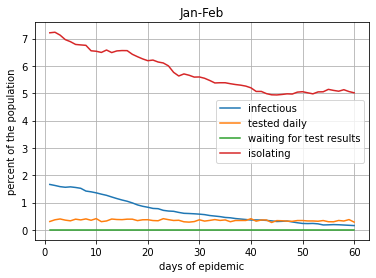

In [8]:
from codit.outbreak_recorder import WardComponent

DAYS_MONTH = 30

o_Jan_Feb = Outbreak(soc, n_days=DAYS_MONTH * 2, population=pop, reset_population=False)
o_Jan_Feb.recorder.add_component(WardComponent(o_Jan_Feb))
o_Jan_Feb.simulate()
o_Jan_Feb.recorder.plot(title="Jan-Feb")

### March 
  1. Open classrooms
  2. People now 'brush past' on average 0.3 others randomly per day (see COMIX)
  3. Vaccinate the over 60s

In [9]:
LOCKDOWN_CFG = dict(classrooms=0.0, workplaces=0.66, ephemeral_contact=0.3)

pop.set_structure(soc, lockdown_config=LOCKDOWN_CFG)
pop.clear_memory()

for i, p in enumerate(pop.people):
    if p.age > 60 and i % 20: # we vaccinate 19 in every 20 people
        p.vaccinate_with("AstraZeneca")

2021-05-16 09:18:50.982 INFO     66.0% of workplaces closed by lockdown, leaving 1618 open, of average Income Decile 4.82 (and st dev 3.11).
2021-05-16 09:18:50.995 INFO     0.0% of classrooms closed by lockdown, leaving 186 open, of average Income Decile 4.69 (and st dev 3.06).
2021-05-16 09:18:50.997 INFO     Adding 17489 permanent contact groups
2021-05-16 09:18:51.011 INFO     Adding 5948 ephemeral contact pairs
2021-05-16 09:18:51.301 INFO     Adding 11404 contacts each within one of the 8382 buildings (contact density of 0.75)


2021-05-16 09:18:53.494 INFO     Day 1, prop infected is 0.16, prop infectious is 0.0016
2021-05-16 09:18:58.406 INFO     Day 30, prop infected is 0.17, prop infectious is 0.0004
2021-05-16 09:18:58.502 INFO      Realized R0 of early infections is 0.70
2021-05-16 09:18:58.503 INFO      16.7 percent of the population was infected during the epidemic


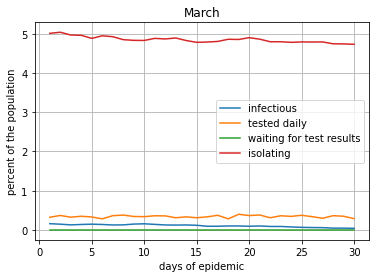

In [10]:
o_March = Outbreak(soc, n_days=DAYS_MONTH, population=pop, reset_population=False)
o_March.recorder.add_component(WardComponent(o_March))
o_March.simulate()
o_March.recorder.plot(title="March")

### April
    1. More workplaces (such as non-essential retail) open up
    2. More people brush past each other as restrictions are lifted
    3. 10 people introduce the Indian variant into the Leeds population
    4. Vaccinate the over 50s

In [11]:
LOCKDOWN_CFG = dict(classrooms=0.0, workplaces=0.5, ephemeral_contact=0.4)

pop.set_structure(soc, lockdown_config=LOCKDOWN_CFG)

pop.seed_infections(10, indian_variant)
pop.clear_memory()

for i, p in enumerate(pop.people):
    if (60 >= p.age > 50) and i % 20: # vaccinate 19 in every 20 people
        p.vaccinate_with("AstraZeneca")

2021-05-16 09:18:58.924 INFO     50.0% of workplaces closed by lockdown, leaving 2458 open, of average Income Decile 4.84 (and st dev 3.11).
2021-05-16 09:18:58.935 INFO     0.0% of classrooms closed by lockdown, leaving 188 open, of average Income Decile 4.72 (and st dev 3.06).
2021-05-16 09:18:58.937 INFO     Adding 18331 permanent contact groups
2021-05-16 09:18:59.174 INFO     Adding 7931 ephemeral contact pairs
2021-05-16 09:18:59.231 INFO     Adding 11527 contacts each within one of the 8382 buildings (contact density of 0.75)


2021-05-16 09:19:01.643 INFO     Day 1, prop infected is 0.17, prop infectious is 0.0005
2021-05-16 09:19:06.997 INFO     Day 30, prop infected is 0.17, prop infectious is 0.0004
2021-05-16 09:19:07.103 INFO      Realized R0 of early infections is 0.93
2021-05-16 09:19:07.103 INFO      17.0 percent of the population was infected during the epidemic


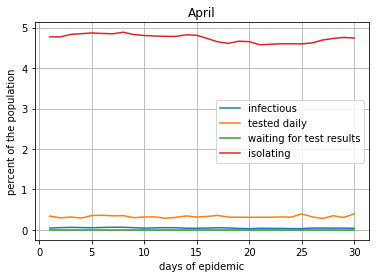

In [12]:
o_April = Outbreak(soc, n_days=DAYS_MONTH, population=pop, reset_population=False)
o_April.recorder.add_component(WardComponent(o_April))
o_April.simulate()
o_April.recorder.plot(title="April")

### May
    1. Even more workplaces open up
    2. More people brush past on average 0.5 others randomly per day


In [13]:
LOCKDOWN_CFG = dict(classrooms=0.0, workplaces=0.33, ephemeral_contact=0.5)
pop.clear_memory()
pop.set_structure(soc, lockdown_config=LOCKDOWN_CFG)

for i, p in enumerate(pop.people):
    if (50 >= p.age > 45) and i % 20: # we vaccinate 19 in every 20 people
        p.vaccinate_with("AstraZeneca")

2021-05-16 09:19:07.566 INFO     33.0% of workplaces closed by lockdown, leaving 3169 open, of average Income Decile 4.86 (and st dev 3.10).
2021-05-16 09:19:07.581 INFO     0.0% of classrooms closed by lockdown, leaving 189 open, of average Income Decile 4.74 (and st dev 3.07).
2021-05-16 09:19:07.583 INFO     Adding 19043 permanent contact groups
2021-05-16 09:19:07.659 INFO     Adding 9914 ephemeral contact pairs
2021-05-16 09:19:07.732 INFO     Adding 11472 contacts each within one of the 8382 buildings (contact density of 0.75)


### Surge Vaccinations all people over 16?

In [14]:
# for p in pop.people:
#     if p.age > 16:
#         p.vaccinate_with('AstraZeneca')

2021-05-16 09:19:10.668 INFO     Day 1, prop infected is 0.17, prop infectious is 0.0004
2021-05-16 09:19:16.227 INFO     Day 30, prop infected is 0.17, prop infectious is 0.0011
2021-05-16 09:19:16.329 INFO      Realized R0 of early infections is 1.31
2021-05-16 09:19:16.329 INFO      17.4 percent of the population was infected during the epidemic


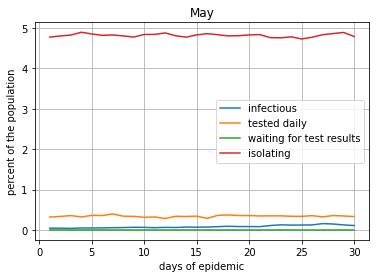

In [15]:
o_May = Outbreak(soc, n_days=DAYS_MONTH, population=pop, reset_population=False)
o_May.recorder.add_component(WardComponent(o_May))
o_May.simulate()
o_May.recorder.plot(title="May")